In [79]:
import os
import pickle
from math import exp
from collections import deque, defaultdict

import numpy as np
import pandas as pd
import networkx as nx
import scipy.sparse as sp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [76]:
def rndm(a, b, g, size=1):
    """Power-law gen for pdf(x) \propto x^{g-1} for a<=x<=b"""
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)

In [77]:
rndm(1, 2, g=-2, size=10)

array([1.53113, 1.43309, 1.29491, 1.26022, 1.27865, 1.13741, 1.00198,
       1.32856, 1.17462, 1.40154])

In [78]:
def pdf(x, a, b, g):
    ag, bg = a**g, b**g
    return g * x**(g-1) / (bg-ag)

In [84]:
[pdf(0.5, x, x+1, 2) for x in range(1, 100)]

[0.3333333333333333,
 0.2,
 0.14285714285714285,
 0.1111111111111111,
 0.09090909090909091,
 0.07692307692307693,
 0.06666666666666667,
 0.058823529411764705,
 0.05263157894736842,
 0.047619047619047616,
 0.043478260869565216,
 0.04,
 0.037037037037037035,
 0.034482758620689655,
 0.03225806451612903,
 0.030303030303030304,
 0.02857142857142857,
 0.02702702702702703,
 0.02564102564102564,
 0.024390243902439025,
 0.023255813953488372,
 0.022222222222222223,
 0.02127659574468085,
 0.02040816326530612,
 0.0196078431372549,
 0.018867924528301886,
 0.01818181818181818,
 0.017543859649122806,
 0.01694915254237288,
 0.01639344262295082,
 0.015873015873015872,
 0.015384615384615385,
 0.014925373134328358,
 0.014492753623188406,
 0.014084507042253521,
 0.0136986301369863,
 0.013333333333333334,
 0.012987012987012988,
 0.012658227848101266,
 0.012345679012345678,
 0.012048192771084338,
 0.011764705882352941,
 0.011494252873563218,
 0.011235955056179775,
 0.01098901098901099,
 0.010752688172043012

In [71]:
graph = nx.bipartite.random_graph(10, 100, p=0.6)

In [75]:
graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109))

In [74]:
X, Y = graph.sets(B)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
nx.draw(B, pos=pos)
plt.show()

AttributeError: 'Graph' object has no attribute 'sets'

In [29]:
np.set_printoptions(precision=5)

Synthesize dataset

In [30]:
node_type = np.asarray([10, 100, 100, 1000])

In [43]:
density = np.random.rand(node_type.shape[0], node_type.shape[0]) / 100
print(density)

[[0.00876 0.00878 0.00473 0.00168]
 [0.00473 0.00635 0.00368 0.00513]
 [0.00992 0.00225 0.0072  0.0009 ]
 [0.00217 0.00108 0.00081 0.00983]]


In [44]:
adj = [[sp.random(x, y, density=d) for y, d in zip(node_type, d_list)] 
       for x, d_list in zip(node_type, density)]

In [45]:
adj = sp.vstack([sp.hstack(x) for x in adj])

In [46]:
adj = adj.tocsr()

In [47]:
adj[adj!=0] = 1

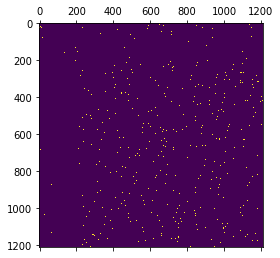

In [48]:
plt.matshow(adj.todense())

In [49]:
adj.nnz / (adj.shape[0]*adj.shape[1])

0.007423673246362953

In [50]:
adj = adj + adj.T

In [51]:
adj[adj!=0] = 1

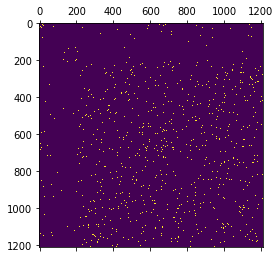

In [52]:
plt.matshow(adj.todense())

In [53]:
adj.nnz / (adj.shape[0]*adj.shape[1])

0.014769482958814289

# Deepwalk를 위한 랜덤 워크 함수 GPU 가속화

In [ ]:
with open(os.path.join('preprocess', 'yelp', 'adj.pickle'), 'rb') as f:
    data = pickle.load(f)

인접 리스트 데이터, 크기, 시작 인덱스 직렬화

In [ ]:
def serialize_adj_indice(data):
    adj_data = [list(data['adj_indice'][x]) for x in range(data['node_num'])]
    adj_size = [len(x) for x in adj_data]
    adj_data = [item for sublist in adj_data for item in sublist]
    adj_start = [None] * data['node_num']
    cnt = 0
    for x in range(data['node_num']):
        adj_start[x] = cnt
        cnt += adj_size[x]
    return adj_data, adj_size, adj_start

In [ ]:
adj_data, adj_size, adj_start = serialize_adj_indice(data)

텐서화

In [ ]:
adj_data = torch.tensor(adj_data, dtype=torch.long)
adj_size = torch.tensor(adj_size, dtype=torch.float)
adj_start = torch.tensor(adj_start, dtype=torch.long)

랜덤 워크 생성

In [ ]:
def deepwalk(v, l, adj_data, adj_size, adj_start):
    """Random walk
    
    Args:
        v (torch.LongTensor): [Batch_size] start index.
        l (int): length of random walk.
        adj_data (torch.LongTensor): [E] data bank for adjacency list.
        adj_size (torch.FloatTensor): [V] degree for each node.
        adj_start (torch.LongTensor): [V] start index for each node in `adj_data`.
    Returns:
        torch.LongTensor [L, B]
    """
    walk = [None] * l
    node = v
    walk[0] = node

    for i in range(1, l):
        offset = torch.floor(torch.rand_like(node, dtype=torch.float) * adj_size[node]).long()
        idx = adj_start[node] + offset
        node = adj_data[idx]
        walk[i] = node
    return torch.stack(walk)

In [ ]:
%time walk = deepwalk(torch.arange(10, dtype=torch.long), 100, adj_data, adj_size, adj_start)

# Metapath2vec을 위한 랜덤 워크 GPU 가속화

In [2]:
with open(os.path.join('preprocess', 'yelp', 'adj_type.pickle'), 'rb') as f:
    data = pickle.load(f)

In [ ]:
data['type_interval']

인접 리스트 데이터, 크기, 시작 인덱스 직렬화 - 타입별로 따로 관리

In [3]:
def serialize_adj_indice(data):
    type_order = list(data['type_interval'].keys())
    adj_data = [data['adj_indice'][x] for x in range(data['node_num'])]
    adj_data = [[list(x[y]) for y in type_order] for x in adj_data]
    adj_size = [[len(y) for y in x] for x in adj_data]
    adj_start = [[None]*len(type_order) for _ in range(data['node_num'])]
    count = 0
    for i in range(data['node_num']):
        for j in range(len(type_order)):
            adj_start[i][j] = count
            count += adj_size[i][j]
    adj_data = [item for sublist in adj_data for subsublist in sublist for item in subsublist]
    return adj_data, adj_size, adj_start, type_order

In [4]:
adj_data, adj_size, adj_start, type_order = serialize_adj_indice(data)

텐서화

In [5]:
adj_data = torch.tensor(adj_data, dtype=torch.long)
adj_size = torch.tensor(adj_size, dtype=torch.float)
adj_start = torch.tensor(adj_start, dtype=torch.long)

랜덤 워크 생성

In [ ]:
type_order

In [ ]:
def metapathwalk(v, v_t, l, metapath, adj_data, adj_size, adj_start):
    """Random walk
    
    Args:
        v (torch.LongTensor): [Batch_size] start index.
        v_t (torch.LongTensor): [Batch_size] type of start node.
        l (int): length of random walk.
        metapath (torch.LongTensor)): metapath
        adj_data (torch.LongTensor): [E] data bank for adjacency list.
        adj_size (torch.FloatTensor): [V] degree for each node.
        adj_start (torch.LongTensor): [V] start index for each node in `adj_data`.
    Returns:
        torch.LongTensor [L, B]
    """
    walk = [None] * l
    node = v
    metapath_idx = torch.tensor([(metapath==x).nonzero()[0] for x in v_t], dtype=torch.long)
    walk[0] = node

    for i in range(1, l):
        metapath_idx = (metapath_idx + 1) % metapath.shape[0]
        adj_size_type = adj_size[node].gather(dim=1, index=metapath[metapath_idx].unsqueeze(1)).squeeze(1)
        assert not torch.any(adj_size_type == 0)
        
        offset = torch.floor(torch.rand_like(node, dtype=torch.float) * adj_size_type).long()
        
        adj_start_type = adj_start[node].gather(dim=1, index=metapath[metapath_idx].unsqueeze(1)).squeeze(1)
        idx = adj_start_type + offset
        
        node = adj_data[idx]
        walk[i] = node
    return torch.stack(walk)

In [ ]:
def get_type(v, type_interval_dict, type_order):
    for k, interval in type_interval_dict.items():
        if interval[0]<= v and v<=interval[1]:
            return type_order.index(k)
    raise Exception

metapath = 'URWRWRBRWRWR'
metapath = torch.tensor([type_order.index(x) for x in metapath], dtype=torch.long)

node = torch.randint(80000, size=(10,), dtype=torch.long)
node_type = [get_type(x, data['type_interval'], type_order) for x in node]

walk = metapathwalk(node, node_type, 100, metapath, adj_data, adj_size, adj_start)

In [ ]:
%time walk = metapathwalk(node, node_type, 100, metapath, adj_data, adj_size, adj_start)

# JUST를 위한 랜덤 워크 GPU 가속화

In [ ]:
def get_type(v, type_interval_dict, type_order):
    for k, interval in type_interval_dict.items():
        if interval[0]<= v and v<=interval[1]:
            return type_order.index(k)
    raise Exception
    
node = torch.randint(80000, size=(10,), dtype=torch.long)
node_type = torch.tensor([get_type(x, data['type_interval'], type_order) for x in node])

In [ ]:
que

In [ ]:
alpha = 0.5

In [ ]:
total_degree = adj_size[node].sum(dim=1, keepdim=True)
homogeneous_degree = adj_size[node].gather(dim=1, index=node_type.unsqueeze(1))
heterogeneous_degree = total_degree - homogeneous_degree

prob_stay = torch.where(homogeneous_degree==0, torch.tensor(0.0), torch.where(heterogeneous_degree==0, torch.tensor(1.0), torch.tensor(alpha)))

In [ ]:
stay = torch.bernoulli(prob_stay)

In [ ]:
homogeneous = torch.zeros_like(adj_size[node])

In [ ]:
homogeneous.scatter_(dim=1, index=node_type.unsqueeze(1), src=torch.tensor(1))

In [ ]:
heterogeneous = (adj_size[node]>0).float()

In [ ]:
heterogeneous.scatter_(dim=1, index=node_type.unsqueeze(1), src=torch.tensor(0))

In [ ]:
heterogeneous_tmp = heterogeneous.clone().detach()

In [ ]:
que = [deque() for _ in range(node.shape[0])]

In [ ]:
for i in range(node.shape[0]):
    heterogeneous[i, que[i]] = 0

In [ ]:
heterogeneous[heterogeneous.sum(dim=1)==0] = heterogeneous[heterogeneous.sum(dim=1)==0]

In [ ]:
heterogeneous

In [ ]:
weight = homogeneous * (stay) + heterogeneous * (1-stay)

In [ ]:
next_type = torch.multinomial(weight, 1)

In [ ]:
next_type

In [ ]:
def justwalk(v, v_t, l, alpha, que_size, adj_data, adj_size, adj_start):
    """Random walk
    
    Args:
        v (torch.LongTensor): [Batch_size] start index.
        v_t (torch.LongTensor): [Batch_size] type of start node.
        l (int): length of random walk.
        alpha (float): stay probability
        que_size (int): the size of queue
        adj_data (torch.LongTensor): [E] data bank for adjacency list.
        adj_size (torch.FloatTensor): [V] degree for each node.
        adj_start (torch.LongTensor): [V] start index for each node in `adj_data`.
    Returns:
        torch.LongTensor [L, B]
    """
    walk = [None] * l
    node = v
    node_type = v_t
    walk[0] = node
    que = [deque() for _ in v.shape[0]]
    stay_l = [1 for _ in v.shape[0]]
    
    for i in range(1, l):
        total_degree = adj_size[node].sum(dim=1, keepdim=True)
        homogeneous_degree = adj_size[node].gather(dim=1, index=node_type.unsqueeze(1))
        heterogeneous_degree = total_degree - homogeneous_degree

        prob_stay = torch.where(homogeneous_degree==0, 
                                torch.tensor(0.0), 
                                torch.where(heterogeneous_degree==0, 
                                            torch.tensor(1.0), 
                                            torch.tensor(alpha ** stay_l)))
        stay = torch.bernoulli(prob_stay)
        
        homogeneous = torch.zeros_like(adj_size[node])
        homogeneous.scatter_(dim=1, index=node_type.unsqueeze(1), src=torch.tensor(1))
        
        heterogeneous = (adj_size[node]>0).float()
        heterogeneous.scatter_(dim=1, index=node_type.unsqueeze(1), src=torch.tensor(0))
        heterogeneous_tmp = heterogeneous.clone().detach()
        for i in range(node.shape[0]):
            heterogeneous[i, que[i]] = 0
        heterogeneous[heterogeneous.sum(dim=1)==0] = heterogeneous_tmp[heterogeneous.sum(dim=1)==0]
        
        weight = homogeneous * (stay) + heterogeneous * (1-stay)
        node_type = torch.multinomial(weight, 1).squeeze(1)
        
        for i in range(node.shape[0]):
            if stay
        adj_size_type = adj_size[node].gather(dim=1, index=node_type.unsqueeze(1)).squeeze(1)
        assert not torch.any(adj_size_type == 0)
        
        offset = torch.floor(torch.rand_like(node, dtype=torch.float) * adj_size_type).long()
        
        adj_start_type = adj_start[node].gather(dim=1, index=node_type.unsqueeze(1)).squeeze(1)
        idx = adj_start_type + offset
        
        node = adj_data[idx]
        walk[i] = node
    return torch.stack(walk)

In [ ]:
torch.where(adj_size[node].gather(dim=1, ))

In [ ]:
(alpha**2) * (adj_size[node]>0).float()

# Balanced2vec을 위한 랜덤 워크 GPU 가속화

In [ ]:
A = torch.randint(1, 3, size=(4, 4)).float()
node = torch.randint(80000, size=(10,), dtype=torch.long)
node_type = torch.tensor([get_type(x, data['type_interval'], type_order) for x in node])

In [ ]:
context_matrix = torch.zeros(10, len(type_order), len(type_order))
go_vector = torch.zeros(10, len(type_order))
back_vector = torch.zeros(10, len(type_order))

In [ ]:
node_type

1번 행동

In [ ]:
_ = back_vector.scatter_(dim=1, index=node_type.unsqueeze(1), src=torch.tensor(0))

2번 행동

In [ ]:
node_type_stack = torch.stack([node_type]*len(type_order)).t().unsqueeze(2)
back_vector += context_matrix.gather(dim=2, index=node_type_stack).squeeze(2)
_ = context_matrix.scatter_(dim=2, index=node_type_stack, src=torch.tensor(0))
_ = go_vector.scatter_(dim=1, index=node_type.unsqueeze(1), src=torch.tensor(0))

3번 행동

In [ ]:
node_type_stack = torch.stack([node_type]*len(type_order)).t().unsqueeze(1)
src = torch.stack([A]*10).gather(dim=1, index=node_type_stack)
_ = context_matrix.scatter_add_(dim=1, index=node_type_stack, src=src)
go_vector += src.squeeze(1)

4번 행동 및 샘플링

In [ ]:
weight = go_vector + back_vector
weight = weight * (adj_size[node] > 0).float()
next_type = torch.multinomial(weight, 1)

In [6]:
def balancewalk(v, v_t, l, A, t, adj_data, adj_size, adj_start):
    """Random walk
    
    Args:
        v (torch.LongTensor): [Batch_size] start index.
        v_t (torch.LongTensor): [Batch_size] type of start node.
        l (int): length of random walk.
        A (torch.FloatTensor)): [T, T] inverse training rate matrix.
        t (int): number of type
        adj_data (torch.LongTensor): [E] data bank for adjacency list.
        adj_size (torch.FloatTensor): [V] degree for each node.
        adj_start (torch.LongTensor): [V] start index for each node in `adj_data`.
    Returns:
        torch.LongTensor [L, B]
    """
    walk = [None] * l
    node = v
    node_type = v_t
    walk[0] = node
    
    # Initialize data structure
    context_matrix = torch.zeros(v.shape[0], t, t)
    go_vector = torch.zeros(v.shape[0], t)
    back_vector = torch.zeros(v.shape[0], t)

    for i in range(1, l):
        # Process 1
        back_vector.scatter_(dim=1, index=node_type.unsqueeze(1), src=torch.tensor(0))
        
        node_type_stack = torch.stack([node_type]*len(type_order)).t()
        
        # Process 2
        back_vector += context_matrix.gather(dim=2, index=node_type_stack.unsqueeze(2)).squeeze(2)
        context_matrix.scatter_(dim=2, index=node_type_stack.unsqueeze(2), src=torch.tensor(0))
        go_vector.scatter_(dim=1, index=node_type.unsqueeze(1), src=torch.tensor(0))
        
        # Process 3
        src = torch.stack([A]*v.shape[0]).gather(dim=1, index=node_type_stack.unsqueeze(1))
        context_matrix.scatter_add_(dim=1, index=node_type_stack.unsqueeze(1), src=src)
        go_vector += src.squeeze(1)
        
        # Process 4
        weight = go_vector + back_vector
        np.set_printoptions(precision=10000, suppress=False)
        weight = weight * (adj_size[node] > 0).float()
        node_type = torch.multinomial(weight, 1).squeeze(1)
        
        adj_size_type = adj_size[node].gather(dim=1, index=node_type.unsqueeze(1)).squeeze(1)
        assert not torch.any(adj_size_type == 0)
        
        offset = torch.floor(torch.rand_like(node, dtype=torch.float) * adj_size_type).long()
        
        adj_start_type = adj_start[node].gather(dim=1, index=node_type.unsqueeze(1)).squeeze(1)
        idx = adj_start_type + offset
        
        node = adj_data[idx]
        walk[i] = node
    return torch.stack(walk)

In [8]:
def get_type(v, type_interval_dict, type_order):
    for k, interval in type_interval_dict.items():
        if interval[0]<= v and v<=interval[1]:
            return type_order.index(k)
    raise Exception

#A = torch.randint(1, 3, size=(4, 4)).float()
A = torch.tensor([[1, 10000, 1, 1], [10000, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1]]).float()
node = torch.randint(80000, size=(1,), dtype=torch.long)
node_type = torch.tensor([get_type(x, data['type_interval'], type_order) for x in node])

In [ ]:
node_type

In [9]:
%timeit walk = balancewalk(node, node_type, 100, A, len(type_order), adj_data, adj_size, adj_start)

22.5 ms ± 1.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
walk = balancewalk(node, node_type, 100, A, len(type_order), adj_data, adj_size, adj_start)
print((torch.tensor([[get_type(x, data['type_interval'], type_order) for x in b] for b in walk])==0).nonzero().shape[0],
(torch.tensor([[get_type(x, data['type_interval'], type_order) for x in b] for b in walk])==1).nonzero().shape[0],
(torch.tensor([[get_type(x, data['type_interval'], type_order) for x in b] for b in walk])==2).nonzero().shape[0],
(torch.tensor([[get_type(x, data['type_interval'], type_order) for x in b] for b in walk])==3).nonzero().shape[0])

In [ ]:
torch.tensor([[get_type(x, data['type_interval'], type_order) for x in b] for b in walk])

In [ ]:
data['class']['T'] = np.full(data['type_interval']['T'][1]-data['type_interval']['T'][0]+1, fill_value=-1)

In [ ]:
class_dict = np.concatenate((data['class']['A'], data['class']['T'], data['class']['V'], data['class']['P']), axis=0)

In [ ]:
def get_class_list(walk, key):
    walk = [x for x in walk if data['type_interval'][key][0]<=x and x<=data['type_interval'][key][1]]
    return [class_dict[x] for x in walk]

In [ ]:
get_class_list(walk, 'V')

In [ ]:
type_str_dict = {x: i for i, x in enumerate(data['type_interval'].keys())}
type_str_inverse_dict = {i: x for x, i in type_str_dict.items()}

In [ ]:
possible_type_mask = torch.zeros(len(data['adj_indice'].keys()), 4)
for k, v in data['adj_indice'].items():
    for k2 in v.keys():
        possible_type_mask[k, type_str_dict[k2]] = 1

In [ ]:
adjacent_node_num_per_type = torch.zeros(data['node_num'], 4, dtype=torch.long)

In [ ]:
for k, v in data['adj_indice'].items():
    for k2, v2 in v.items():
        adjacent_node_num_per_type[k, type_str_dict[k2]] = len(v2)

In [ ]:
adjacent_node_num_per_type

In [ ]:
start_idx = torch.zeros(data['node_num'], 4, dtype=torch.long)
tmp = torch.zeros(4, dtype=torch.long)
for i in range(data['node_num']):
    start_idx[i, :] = tmp
    tmp += adjacent_node_num_per_type[i]

In [ ]:
packed_adj = [None] * 4
for type_k, type_idx in type_str_dict.items():
    packed_adj[type_idx] = [None] * data['node_num']
    for k, v in data['adj_indice'].items():
        packed_adj[type_idx][k] = torch.tensor(list(v[type_k]) if v.get(type_k) is not None else [], dtype=torch.long)
    packed_adj[type_idx] = torch.cat(packed_adj[type_idx], dim=0)
pad_packed_adj = nn.utils.rnn.pad_sequence(packed_adj)
print(pad_packed_adj.shape)

In [ ]:

def get(pad_packed_adj, start_idx, adjacent_node_num_per_type, node, idx, type_):
    return pad_packed_adj[start_idx[node, type_]+idx, type_]


In [ ]:
get(pad_packed_adj, 
    start_idx, 
    adjacent_node_num_per_type, 
    torch.tensor([19999, 20000], dtype=torch.long), 
    torch.tensor([0, 0], dtype=torch.long), 
    torch.tensor([3, 1], dtype=torch.long))

In [ ]:
type_attention = torch.from_numpy(np.asarray([[1, 1, 1, 1], [1, 1, 1, 1], [100, 1, 1, 1], [1, 1, 1, 1]])).cuda()

In [ ]:
pad_packed_adj = pad_packed_adj.cuda()
start_idx = start_idx.cuda()
adjacent_node_num_per_type = adjacent_node_num_per_type.cuda()
possible_type_mask = possible_type_mask.cuda()

In [ ]:
import time

class BalancedWalkFactory(object):
    def __init__(self,
                 possible_type_mask,
                 adjacent_node_num_per_type,
                 start_idx,
                 pad_packed_adj,
                 type_attention,
                 type_str_dict):
        self.possible_type_mask = possible_type_mask
        self.adjacent_node_num_per_type = adjacent_node_num_per_type
        self.start_idx = start_idx
        self.pad_packed_adj = pad_packed_adj
        self.type_attention = type_attention
        self.type_str_dict = type_str_dict
    
    def to(self, device):
        self.possible_type_mask = self.possible_type_mask.to(device)
        self.adjacent_node_num_per_type = self.adjacent_node_num_per_type.to(device)
        self.start_idx = self.start_idx.to(device)
        self.pad_packed_adj = self.pad_packed_adj.to(device)
        self.type_attention = self.type_attention.to(device)
        return self
        
    def __call__(self, v, l):
        batch_size = v.shape[0]
        walk = v.new_zeros(l, batch_size, dtype=torch.long)
        walk[0, :] = v

        history = v.new_zeros(l, batch_size, 4, dtype=torch.long)
        return_history = v.new_full((l, batch_size), fill_value=-1, dtype=torch.long)
        to_prob = v.new_zeros(batch_size, 4, dtype=torch.long)

        cur_type = v.new_tensor([self.type_str_dict[get_type(x, data['type_interval'])] for x in walk[0, :]], dtype=torch.long)

        for i in range(1, l):
            history[i-1, :, :] = type_attention[cur_type]
            return_history[i-1, :] = cur_type
            prob = history.sum(dim=0)
            prob += to_prob
            prob *= possible_type_mask[walk[i-1,:]].long()
    
            nxt_type = torch.multinomial(prob.float(), 1)
            idx = torch.rand(batch_size).cuda()
            size = torch.gather(adjacent_node_num_per_type[walk[i-1,:]], 1, nxt_type).squeeze()
    
            idx = torch.floor(idx * size.float()).long()
    
            walk[i, :] = get(pad_packed_adj, 
                             start_idx, 
                             adjacent_node_num_per_type, 
                             walk[i-1, :], 
                             idx, 
                             nxt_type.squeeze())
            cur_type = nxt_type.squeeze()
        
            to_prob.scatter_(dim=1, index=nxt_type, src=torch.tensor(0))
            for j in range(i):
                to_prob.scatter_add_(dim=1, index=return_history[[j], :].t(), 
                                 src=torch.gather(history[j, :, :], dim=1, index=nxt_type))
                history[j, :, :].scatter_(dim=1, index=nxt_type, src=torch.tensor(0))
        return walk

balanced_walk = BalancedWalkFactory(possible_type_mask,
                                    adjacent_node_num_per_type,
                                    start_idx,
                                    pad_packed_adj,
                                    torch.from_numpy(np.asarray([[1, 1, 1, 1], [1, 1, 1, 1], [100, 1, 1, 1], [1, 1, 1, 1]])),
                                    type_str_dict)
balanced_walk = balanced_walk.to(torch.device("cuda:0"))

start_time = time.time()

for _ in range(5):
    walk = balanced_walk(torch.arange(0, 100, 1).cuda(), 80)

print('--- %s seconds ---' % (time.time() - start_time))
print(walk.shape)

In [ ]:
def balanced_walk(v, adj, type_interval, type_str_dict, type_str_inverse_dict, type_, l): 
    walk = [v] * l 
    from_que = deque()
    to_prob = np.asarray([0] * 4)
    for i in range(1, l): 
        cur_type = type_str_dict[get_type(walk[i-1], type_interval)]
        possible_type = list(map(type_str_dict.get, adj[walk[i-1]].keys()))

        # From que update
        from_que.append((cur_type, np.copy(type_[cur_type])))

        # Calculate probability
        prob = np.asarray([0] * 4, dtype=np.float32)
        for _, p in from_que:
            prob += p
        prob += to_prob

        nxt_type = np.random.choice(possible_type, 1, p=prob[possible_type]/prob[possible_type].sum())[0]
        walk[i] = np.random.choice(list(adj[walk[i-1]][type_str_inverse_dict[nxt_type]]), 1)[0]

        # To prob update
        to_prob[nxt_type] = 0 
        for return_type, p in from_que:
            to_prob[return_type] += p[nxt_type]
            p[nxt_type] = 0 

        while len(from_que) > 0:
            if np.all(from_que[0]==0):
                from_que.popleft()
            else:
                break
    return walk

In [ ]:
walk = walk.cpu().numpy()

In [ ]:
count_df_list = []

for i in range(1000):
    walk = balanced_walk(1, 
                     data['adj_indice'], 
                     data['type_interval'], 
                     type_str_dict,
                         type_str_inverse_dict,
                     np.asarray([[1, 1, 1, 1], [1, 1, 1, 1], [100, 1, 1, 1], [1, 1, 1, 1]]), 
                     40)
    df = pd.DataFrame({'walk': walk, 'class': [class_dict[x] for x in walk], 'type': [get_type(x, data['type_interval']) for x in walk]})
    count_df_list.append(df.groupby('type').count())
    

In [ ]:
#walk = walk[:, 0].cpu().numpy()
df = pd.DataFrame({'walk': walk, 'class': [class_dict[x] for x in walk], 'type': [get_type(x, data['type_interval']) for x in walk]})

    

In [ ]:
count_df_list = []
count_df_list.append(df.groupby('type').count())

In [ ]:
pd.concat(count_df_list).groupby('type').sum()

In [ ]:
df

In [ ]:
df[df['type']=='P']